# Module Imports

In [166]:
from pyparsing import match_only_at_col
import requests
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xlsxwriter
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from datetime import date
from datetime import datetime
from json import loads
from PIL import Image

pd.set_option('display.max_rows', 30)

# Defining Functions

In [167]:
def api2df(requestAddr):

    #Making the API Request
    print(f'Making API Call to: {requestAddr}')
    response = requests.get(requestAddr)
    if response.status_code == 200:
        print('API Request Successful')
    elif response.status_code == 404:
        print('API Request Failed')
        KeyboardInterrupt

    #Converting JSON to Dict and Parsing API Data into a Dataframe
    dict = loads(response.text)

    return dict


#Function to Detect Operating System and Adjust Pathing to Respective Filesystem
def pathing(filename):

    #Windows Operating System
    if 'win' in sys.platform:
        filepath = f'{sys.path[0]}\\{filename}'
    #Linux/Mac Operating Sytem
    else:
        filepath = f'{sys.path[0]}/{filename}'

    return filepath

#Function for Writing .xlsx Data Tables which will provide a standard output for table formatting 
def xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer):

    #Layout/Formatting
    t_vert_spacing = 5 #Vertical Spacing between tables
    t_horz_spacing = 1 #Horizontal Spacing between tables
    title_format = workbook.add_format({'bold': True, 'font_size' : 20, 'fg_color' : '#76933C', 'font_color' : 'white' }) #Standardised Title Format for all tables
    header_format = workbook.add_format({'bold' : True, 'font_size' : 12, 'text_wrap' : True}) #text-wrapping for table headers
    
    # Adding and changing active sheet
    try:
        worksheet=workbook.add_worksheet(sheet_name)
        writer.sheets[sheet_name] = worksheet 
        worksheet.set_zoom(70)
        startrow = 3
        startcol = 1
    except:
        pass

    for i in range(len(col_width_list)):
        worksheet.set_column(i+startcol, i+startcol, col_width_list[i])

    #Writing in Cell Data and Merging Cells for Table Titles
    data_table.to_excel(writer,sheet_name=sheet_name,startrow=startrow , startcol=startcol, index=False, header=False)
    worksheet.merge_range(startrow-2, startcol,startrow-2,data_table.shape[1] + startcol -1, title_str,title_format) #writing in title formatting above table

    #Column settings to use in add table function
    column_settings = [{'header' : column} for column in data_table.columns]

    #Populating Excel with Table Format - Adding table to xls for each df
    worksheet.add_table(startrow-1, startcol, startrow + data_table.shape[0], data_table.shape[1] + startcol - 1, {'columns' : column_settings, 'style': 'Table Style Medium 4', 'autofilter' : False})   

    #Applying a text wrap to the Column Header
    for col_num, value in enumerate(data_table.columns.values):
        worksheet.write(startrow-1, col_num + startcol, value, header_format)
    
    #Setting Positions of Following Tables Insertions
    startrow = startrow + data_table.shape[0] + t_vert_spacing #Setting to start row for next table
    # startrow = 3  
    # startcol = startcol + data_table.shape[1] + t_horz_spacing  #Disabling horizontally displaced tables in favour of vertically displacements
    startcol = 1

    #Setting the column width at the end of the table to keep to spacing minimal between tables
    worksheet.set_column(startcol-1,startcol-1,1)
    
    #Return the start row in order to index for future function calls
    return [startrow,startcol,worksheet,workbook,writer]

# Date Variables

In [168]:
date_today = date.today()
date_today_unix = int(datetime.now().timestamp())
date_today_str = date_today.strftime("%d-%B-%Y")

# API Requests and Processing Data
### Civilisation Data

In [169]:
#Address for Requesting Age of Empires 2 Leaderboard Data
data='strings'     #Return Keys For the Game String Data
requestAddr = f'https://aoe2.net/api/{data}?game=aoe2de'
dict = api2df(requestAddr)
df = pd.DataFrame.from_dict(dict,orient='index')

#Parsing the civilisation data into a dataframe
print('Generating Keys For Civilisation String Data')
dict = df.loc['civ',0]
df_civ = pd.DataFrame.from_dict(dict)

#Re-naming id column to merge civ data into other tables
df_civ.rename(columns={'id':'id_civ','string':'civilisation'},inplace=True)
df_civ

Making API Call to: https://aoe2.net/api/strings?game=aoe2de
API Request Successful
Generating Keys For Civilisation String Data


,id_civ,civilisation
0,1,Britons
1,2,Franks
2,3,Goths
3,4,Teutons
4,5,Japanese
...,...,...
38,39,Bohemians
39,40,Dravidians
40,41,Bengalis
41,42,Gurjaras


### Leaderboard Data

In [179]:
#Requesting Age of Empires 2 Leaderboard Data
data='leaderboard'
leaderboard_id = 3 #3 = Random Map Leaderboard
count = 100         #Extracting this many entries from table
count_leader_xlsx = count       #(for xlsxwriter title)
requestAddr = f'https://aoe2.net/api/{data}?game=aoe2de&leaderboard_id={leaderboard_id}&start=1&count={count}'
dict = api2df(requestAddr)
df = pd.DataFrame.from_dict(dict,orient='index')

#Parsing the leaderboard data into a dataframe
print(f'Generating Leaderboard History for the top {count} players')
dict = df.loc['leaderboard',0]
leaderboard = pd.DataFrame.from_dict(dict)

#Taking the Intersection of Column Headers and grabbing top 15 players
rating_top = leaderboard[leaderboard.columns.intersection(['steam_id','name','rating','country','games','wins','losses'])]
rating_top_xlsx = rating_top.copy()       #Preserving Table for xlsxwriter output
rating_top = rating_top.head(15)
rating_top = rating_top.iloc[::-1] #Flipping table upside down for purposes of plot data order
rating_top
# leaderboard

Making API Call to: https://aoe2.net/api/leaderboard?game=aoe2de&leaderboard_id=3&start=1&count=100
API Request Successful
Generating Leaderboard History for the top 100 players


,rating,steam_id,name,country,games,wins,losses
14,2466,76561198152110843,mYi.PROject_Belgium,BE,3391,1991,1400
13,2483,76561198099659716,Capoch,AR,1187,722,465
12,2488,76561197992981071,dogao,BR,1422,1060,362
11,2496,76561198275359848,_Barles_,PL,2052,1282,770
10,2503,76561198364718180,ACCM |AOEbuilds.com,VN,2846,1939,907
9,2513,76561198807828662,SalzZ_classicpro,UA,1335,821,514
8,2516,76561198011417995,Modri,SI,822,520,302
7,2521,76561198027378107,Nicov,AR,1281,938,343
6,2524,76561198179087382,_WWP_Yo,CN,1547,985,562
5,2531,76561199032160044,The Last AMIGO,SI,507,320,187


### Top Player Rating History

In [171]:
#Requesting Player Rating History
data = 'ratinghistory'  #Returning Rating Data
leaderboard_id = 3      #3 = Random Map Leaderboard
count = 500             #Extracting this many entries from table
top_player_id = rating_top.loc[0,'steam_id'] #Nesting the top player id from previous API call into the following request
top_player_name = rating_top.loc[0,'name']   #Grabbing name to place into chart title
requestAddr = f'https://aoe2.net/api/player/{data}?game=aoe2de&leaderboard_id={leaderboard_id}&steam_id={top_player_id}&count={count}'
dict = api2df(requestAddr)

#Parsing Player Rating History into Table
print(f'Generating Rating History for {top_player_name} over the last {count} games')
df_player_hist = pd.DataFrame.from_dict(dict,orient='columns')
df_player_hist['match_date'] = ''
df_player_hist['win_loss'] = ''

#Looping through DataFrame to prepare more data for analysis
for i in range(df_player_hist.shape[0]):

    #Since the timestamps are UNIX based, we need to convert them into DateTime Format so they are readable
    ts = df_player_hist.iat[i,df_player_hist.columns.get_loc('timestamp')]
    df_player_hist.iat[i,df_player_hist.columns.get_loc('match_date')] = datetime.fromtimestamp(ts)

    #Determine if match was a win or a loss (represented by an W or L string)
    i_b = i+1 #Create index value for match b to grab previous match
    if i_b != df_player_hist.shape[0]:

        match_a = df_player_hist.iat[i,df_player_hist.columns.get_loc('num_wins')]
        match_b = df_player_hist.iat[i_b,df_player_hist.columns.get_loc('num_wins')]

        if match_a > match_b:
            df_player_hist.iat[i,df_player_hist.columns.get_loc('win_loss')] = 'W'
        else:
            df_player_hist.iat[i,df_player_hist.columns.get_loc('win_loss')] = 'L'

    #Can't determine a win/loss for the final iteration so we have to drop the last row
    else:
        df_player_hist = df_player_hist[:-1]
    
#Performing Groupby Operation To Determine Monthly Statistics
df_player_hist = df_player_hist.groupby(['match_date','win_loss'])['win_loss'].count()
df_player_hist = df_player_hist.groupby([pd.Grouper(level='match_date',freq='1M'),'win_loss']).sum().unstack('win_loss')
df_player_hist.index = pd.to_datetime(df_player_hist.index).strftime('%b-%y')
df_player_hist

Making API Call to: https://aoe2.net/api/player/ratinghistory?game=aoe2de&leaderboard_id=3&steam_id=76561198000635167&count=500
API Request Successful
Generating Rating History for SalzZ_Vinchester over the last 500 games


win_loss,L,W
match_date,,
Nov-20,14,17
Dec-20,16,33
Jan-21,7,13
Feb-21,4,10
Mar-21,5,9
Apr-21,1,6
May-21,4,9
Jun-21,6,9
Jul-21,2,1


### Top Player Match History

In [172]:
#Requesting Top Player Match History
data = 'matches'        #Returning Match Data
leaderboard_id = 3      #3 = Random Map Leaderboard
count = 300              #Extracting this many entries from table
count_match_xlsx = count       #(for xlsxwriter title)
since = date_today_unix #Extracting Match History From This Date
top_player_id = rating_top.loc[0,'steam_id'] #Nesting the top player id from previous API call into the following request
top_player_name = rating_top.loc[0,'name']   #Grabbing name to place into chart title
requestAddr = f'https://aoe2.net/api/player/{data}?game=aoe2de&leaderboard_id={leaderboard_id}&steam_id={top_player_id}&count={count}&since={since}'
dict = api2df(requestAddr)

#Parsing Player Match History into Table
print(f'Generating Match History For {top_player_name} over the last {count} games')
df = pd.DataFrame.from_dict(dict,orient='columns')

match_list = [] #Initialise empty list
for i in range(df.shape[0]):
    #Each dict inside the iterable list corresponds to a player in any given match_id
    match_id = {'match_id':df.loc[i,'match_id']}
    i_player_match = df.loc[i,'players']
    #This nested loop appends all the player data to a list
    for j in range(len(i_player_match)):
        i_player_match[j].update(match_id)
        match_list.append(i_player_match[j])
   
#Transforming the List of dictionaries into a dataframe with the Top Player vs Opponents
df_player_matches = pd.json_normalize(match_list)

#Adding Extra Column to the Table and Determine if player is the opponent
df_player_matches['player'] = ''
for i in range (df_player_matches.shape[0]):
    if df_player_matches.iat[i,df_player_matches.columns.get_loc('name')] == top_player_name:
        df_player_matches.iat[i,df_player_matches.columns.get_loc('player')] = top_player_name
    else:
        df_player_matches.iat[i,df_player_matches.columns.get_loc('player')] = 'enemy'

df_player_matches

#Re-arranging DataFrame to Move The Match_id to the front of the table
move_column = df_player_matches.pop('match_id')
df_player_matches.insert(0,move_column.name,move_column)

#Renaming civ col to id_civ to be used as a key for merging in civilisation data
df_player_matches.rename(columns={'civ':'id_civ'},inplace=True)

#Merging in Civilisation Data
df_player_matches = pd.merge(df_player_matches,df_civ,how='left')

#Filtering rating_change to non-NaN
df_player_matches = df_player_matches.loc[df_player_matches['rating_change'].isnull() == False]

df_player_matches
# df

Making API Call to: https://aoe2.net/api/player/matches?game=aoe2de&leaderboard_id=3&steam_id=76561198000635167&count=300&since=1653608492
API Request Successful
Generating Match History For SalzZ_Vinchester over the last 300 games


,match_id,profile_id,steam_id,name,clan,country,slot,slot_type,rating,rating_change,...,wins,streak,drops,color,team,id_civ,civ_alpha,won,player,civilisation
52,161295608,227947,76561197970397646,greX,None,AT,1,1,1877.0,18.0,...,None,None,None,4,1,27,2,True,enemy,Berbers
53,161295608,339762,76561198105728235,Golgoy,None,BE,2,1,2199.0,-12.0,...,None,None,None,5,2,4,38,False,enemy,Teutons
54,161295608,2189304,76561198857733899,Giovanni Giorgio,None,IN,3,1,2022.0,18.0,...,None,None,None,6,1,31,40,True,enemy,Vietnamese
55,161295608,1683622,76561198239970176,beenowu2000,None,HK,4,1,1911.0,-12.0,...,None,None,None,1,2,34,11,False,enemy,Cumans
56,161295608,768063,76561198047579312,Onkar,None,IN,5,1,2698.0,18.0,...,None,None,None,2,1,40,12,True,enemy,Dravidians
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,151405520,271202,76561198000635167,SalzZ_Vinchester,None,RU,2,1,2468.0,-8.0,...,None,None,None,3,2,35,21,False,SalzZ_Vinchester,Lithuanians
878,151249147,658565,76561198797909571,[bK] Paganini,None,BR,1,1,2210.0,-4.0,...,None,None,None,2,1,31,37,False,enemy,Vietnamese
879,151249147,271202,76561198000635167,SalzZ_Vinchester,None,RU,2,1,2466.0,2.0,...,None,None,None,3,2,16,25,True,SalzZ_Vinchester,Mayans
882,151135433,271202,76561198000635167,SalzZ_Vinchester,None,RU,1,1,2465.0,1.0,...,None,None,None,6,1,33,34,True,SalzZ_Vinchester,Tatars


### Exporting Match History Using Xlsxwriter and Formatting Excel Workbook
#### Initialising Workbook Instance

In [173]:
#----------------------------------------------------------------------------------------------------------------------
#--------------------------------------------.xlsx workbook initialisation---------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

#Excel Output Filename
filename = 'AoE2_tabular.xlsx'
filepath = pathing(filename)

#Generating .xls workbook in which to record dataframes for usage.
writer = pd.ExcelWriter(filepath,engine='xlsxwriter')   
workbook=writer.book
worksheet='' #Initialise variable
startrow = 0 #Initialise variable
startcol = 0 #Initialise variable
counter = 0 #Initialise variable

#Looping through the list of countries to chart all the data per country
chart_index = 0 #initialise counter to index vertical chart insertions
lr_pos = 0 #initialise left right insertion variable

#----------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

### Entering Inputs For Selected Worksheet and Running Function Over Tables

In [174]:
#Leadboard Table
data_table = rating_top_xlsx
sheet_name = 'leaderboard'
title_str = f'Leaderboard History for the top {count_leader_xlsx} players'
col_width_list = [6,25,25,10,10,10,10]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

#Top 1 Player Ranked Match History Details
data_table = df_player_matches
sheet_name = 'match_data'
title_str = f'{top_player_name} Match History over the last {count_match_xlsx} games'
col_width_list = [15,15,23,23,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,23,15,15,15]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

#Save into Excel and Exit Python out of File
writer.close()

### Grouping Top Player Match History

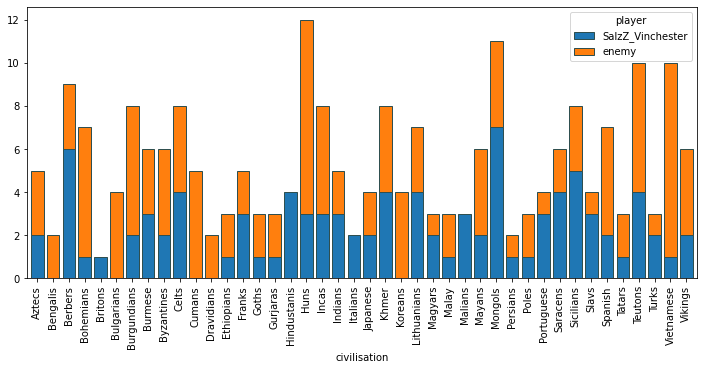

In [175]:
df_player_matches_grouped = df_player_matches.groupby(['civilisation','player'])['civilisation'].count().unstack('player')
df_player_matches_grouped
fig, ax = plt.subplots(figsize=(12,5))
ax = df_player_matches_grouped.plot(kind='bar',ax=ax,width=0.8,edgecolor='darkslategrey',stacked='True')

# Visualising Data
### Plotting Ratings Data

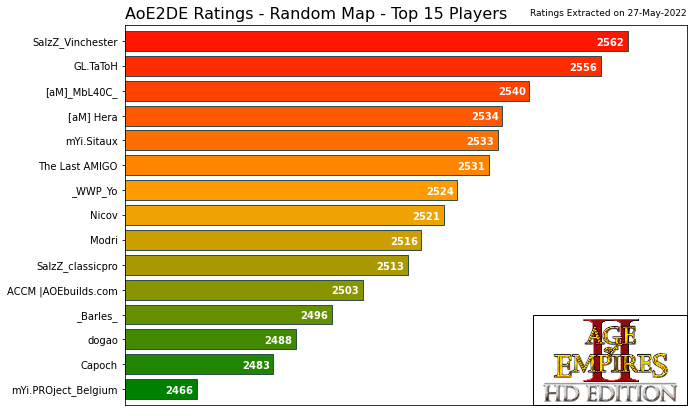

In [180]:
#Plotting and Configuring Chart
#Making a colormap to map onto the bar chart
clist = [(0, "green"), (0.5, "orange"), (1, "red")]
rvb = mcolors.LinearSegmentedColormap.from_list('',clist)
df_arange = np.arange(rating_top.shape[0]).astype(float)

#Setting Axis Limits
lhs_axis_lim = 2450
rhs_axis_lim = 2575

#Plotting a Leaderboard/Ratings Chart
fig, ax = plt.subplots(figsize=(12,7))
ax = rating_top.plot('name','rating',kind='barh',ax=ax,width=0.8,color=rvb(df_arange/rating_top.shape[0]),edgecolor='darkslategrey')
ax.set_title(f'AoE2DE Ratings - Random Map - Top 15 Players',loc='left',fontsize=16)
plt.text(rhs_axis_lim,15,f'Ratings Extracted on {date_today_str}',fontsize =9,horizontalalignment='right')

#Inserting AoE2 Logo on Existing Chart
filename = 'AoE2Logo.png'
filepath = pathing(filename)
image = Image.open(filepath) #Reading Image Data
[width,height] = image.size
im_zoom = 0.15
imagebox = OffsetImage(image,zoom=im_zoom)
aoe2Logo = AnnotationBbox(imagebox 
                        ,[rhs_axis_lim,0],xybox=(-width*im_zoom,height*im_zoom/1.21)
                        , boxcoords='offset points', box_alignment=(0,1)
                        ,pad=0
                        )
ax.add_artist(aoe2Logo)

#Adjusting Plot Parameters
ax.get_legend().remove()
ax.set_ylabel('')
plt.xlim(lhs_axis_lim,rhs_axis_lim)
plt.xticks([])
plt.subplots_adjust(left=0.25) #adjusting plot to prevent y-tick cutoff

#----Data Labels-----
text_offset = 0.175 #Text Offset Distance
for i in range(rating_top.shape[0]):
    rating_value = rating_top.iat[i,rating_top.columns.get_loc('rating')]
    rating_pos = rating_value - 6.1
    if rating_value != 0:
        rating_value = int(rating_value)
        rating_pos = int(rating_pos)
        ax.text(rating_pos,i-text_offset,rating_value,fontsize=10,color='white',weight='bold')
#----Data Labels-----

#Saving graph
filename = 'AoE2_Ratings.png'
filepath = pathing(filename)
plt.savefig(filepath,dpi=100)

#-------------------------------------------------------------------------------------------------------------------------------------



### Plotting Top Player Match History

(0.0, 60.0)

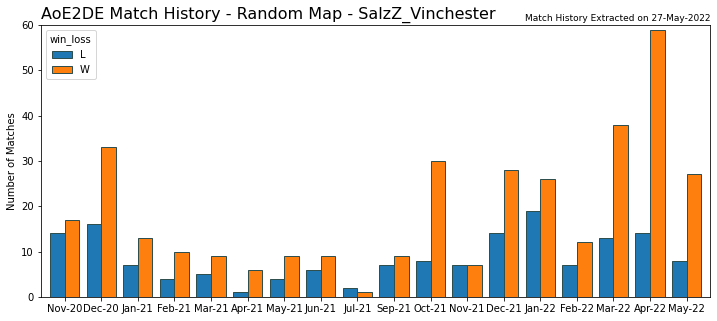

In [177]:
#Plotting a Player History Chart
upper_ylim = 60 #Setting upper bound of y-axis

fig, ax = plt.subplots(figsize=(12,5))
ax = df_player_hist.plot(kind='bar',ax=ax,width=0.8,edgecolor='darkslategrey')
ax.set_title(f'AoE2DE Match History - Random Map - {top_player_name}',loc='left',fontsize=16)
plt.text(df_player_hist.shape[0]-0.35,upper_ylim+1,f'Match History Extracted on {date_today_str}',fontsize =9,horizontalalignment='right')
ax.set_ylabel('Number of Matches', fontsize=10)
ax.set_xlabel('')
ax.tick_params(axis='x',labelrotation= 0,labelsize=10)
plt.ylim(0,upper_ylim) #Setting y-lim